In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from pandas import DataFrame
from pandas import concat

            Temp
Date            
1981-01-01  20.7
1981-01-02  17.9
1981-01-03  18.8
1981-01-04  14.6
1981-01-05  15.8


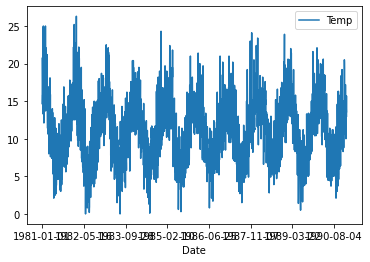

In [ ]:
# Load data
series = pd.read_csv('https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv', header=0, index_col=0)
print(series.head())
series.plot()
plt.show()

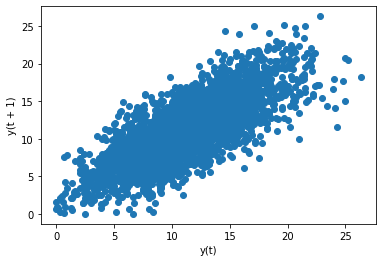

In [ ]:
# Lag plot to check correlation
pd.plotting.lag_plot(series)
plt.show()

It clearly shows a relationship or some correlation.

In [ ]:
values = DataFrame(series.values)
dataframe = concat([values.shift(1), values], axis=1)
dataframe.columns = ['t-1', 't+1']
result = dataframe.corr()
print(result)

         t-1      t+1
t-1  1.00000  0.77487
t+1  0.77487  1.00000


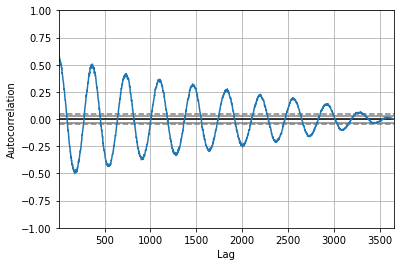

In [ ]:
# Auto-correlation plot
pd.plotting.autocorrelation_plot(series)
plt.show()

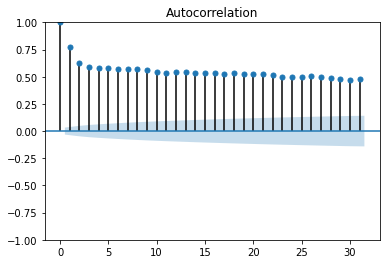

In [ ]:
# The statsmodels library also provides a version of the plot in the plot_acf() function as a line plot.
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(series, lags=31)
plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error

In [ ]:
# split into train and test sets
X = dataframe.values
train, test = X[1:len(X)-7], X[len(X)-7:]
train_X, train_y = train[:,0], train[:,1]
test_X, test_y = test[:,0], test[:,1]

**Persistence Model**

In [ ]:
# persistence model
def model_persistence(x):
	return x

In [ ]:
# walk-forward validation
predictions = list()
for x in test_X:
	yhat = model_persistence(x)
	predictions.append(yhat)
test_score = mean_squared_error(test_y, predictions)
print('Test MSE: %.3f' % test_score)

Test MSE: 3.423


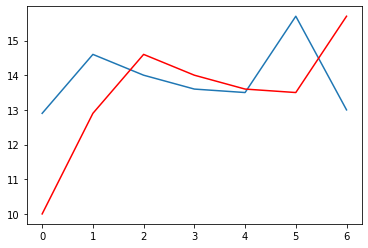

In [ ]:
# plot predictions vs expected
plt.plot(test_y)
plt.plot(predictions, color='red')
plt.show()

**Autoregression Model**

In [ ]:
!pip install statsmodels --upgrade

In [ ]:
from statsmodels.tsa.ar_model import AutoReg
from math import sqrt

In [ ]:
# split dataset
X = series.values
train, test = X[1:len(X)-7], X[len(X)-7:]

# train autoregression
model = AutoReg(train, lags=29)
model_fit = model.fit()
print('Coefficients: %s' % model_fit.params)

Coefficients: [ 5.57543506e-01  5.88595221e-01 -9.08257090e-02  4.82615092e-02
  4.00650265e-02  3.93020055e-02  2.59463738e-02  4.46675960e-02
  1.27681498e-02  3.74362239e-02 -8.11700276e-04  4.79081949e-03
  1.84731397e-02  2.68908418e-02  5.75906178e-04  2.48096415e-02
  7.40316579e-03  9.91622149e-03  3.41599123e-02 -9.11961877e-03
  2.42127561e-02  1.87870751e-02  1.21841870e-02 -1.85534575e-02
 -1.77162867e-03  1.67319894e-02  1.97615668e-02  9.83245087e-03
  6.22710723e-03 -1.37732255e-03]


In [ ]:
# make predictions
predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)
for i in range(len(predictions)):
	print('predicted=%f, expected=%f' % (predictions[i], test[i]))
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)

predicted=11.871275, expected=12.900000
predicted=13.053794, expected=14.600000
predicted=13.532591, expected=14.000000
predicted=13.243126, expected=13.600000
predicted=13.091438, expected=13.500000
predicted=13.146989, expected=15.700000
predicted=13.176153, expected=13.000000
Test RMSE: 1.225


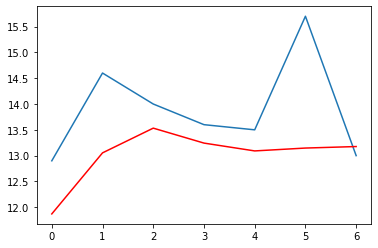

In [ ]:
# plot results
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()

The statsmodels API does not make it easy to update the model as new observations become available.

One way would be to re-train the AutoReg model each day as new observations become available, and that may be a valid approach, if not computationally expensive.

An alternative would be to use the learned coefficients and manually make predictions. This requires that the history of 29 prior observations be kept and that the coefficients be retrieved from the model and used in the regression equation to come up with new forecasts.

predicted=11.871275, expected=12.900000
predicted=13.659297, expected=14.600000
predicted=14.349246, expected=14.000000
predicted=13.427454, expected=13.600000
predicted=13.374877, expected=13.500000
predicted=13.479991, expected=15.700000
predicted=14.765146, expected=13.000000
Test RMSE: 1.204


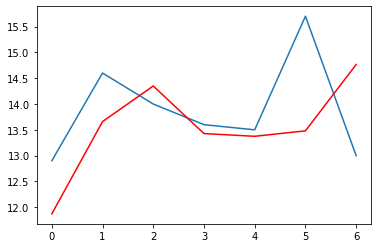

In [ ]:
# split dataset
X = series.values
train, test = X[1:len(X)-7], X[len(X)-7:]

# train autoregression
window = 29
model = AutoReg(train, lags=29)
model_fit = model.fit()
coef = model_fit.params

# walk forward over time steps in test
history = train[len(train)-window:]
history = [history[i] for i in range(len(history))]
predictions = list()
for t in range(len(test)):
	length = len(history)
	lag = [history[i] for i in range(length-window,length)]
	yhat = coef[0]
	for d in range(window):
		yhat += coef[d+1] * lag[window-d-1]
	obs = test[t]
	predictions.append(yhat)
	history.append(obs)
	print('predicted=%f, expected=%f' % (yhat, obs))
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)

# plot
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()